In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import resnet50

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy

from datasets import load_from_disk

np.random.seed(42)

/home/thesis/anaconda3/envs/sg-diff/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

In [2]:
#DATASET = 'CelebA_male_Smiling'
DATASET = 'CelebA_drift_simulated_with_Male_Wearing_Earrings'

dataset = load_from_disk(f"data/CelebA/{DATASET}")

# Select the first 100.000 sample to save ram
dataset["historical_train"] = dataset["historical_train"]#.select(range(10000))

num_train = dataset["historical_train"].num_rows
num_validation = dataset["historical_test"].num_rows
num_test = dataset["datastream_no_drift"].num_rows
num_test_drift = dataset["datastream_drift"].num_rows

In [3]:
print("Train split (historical_train):{}, \n"
      "Validation split (historical_test):{}, \n"
      "Test split (datastream_no_drift):{}, \n"
      "Test split (datastream_drift):{}".format(num_train, num_validation, num_test, num_test_drift))

Train split (historical_train):155951, 
Validation split (historical_test):19114, 
Test split (datastream_no_drift):19076, 
Test split (datastream_drift):1349


In [4]:
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        #image = Image.open(BytesIO(item['image']))
        #image = Image.open(item['image'])
        image = item['image']
        label = 1. if item['Male'] else 0.
        #print(type(image))

        if self.transform:
            image = self.transform(image)

        return image, label, idx


class HFDatasetWrapper_drift(Dataset):
    def __init__(self, hf_dataset_nodrift, hf_dataset_drift, transform=None):
        self.hf_dataset_nodrift = hf_dataset_nodrift
        self.hf_dataset_drift = hf_dataset_drift
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset_nodrift) + len(self.hf_dataset_drift)

    def __getitem__(self, idx):
        item = self.hf_dataset_nodrift[idx] if idx < len(self.hf_dataset_nodrift) else self.hf_dataset_drift[idx - len(self.hf_dataset_nodrift)]
        #image = Image.open(BytesIO(item['image']))
        #image = Image.open(item['image'])
        image = item['image']
        label = 0. if idx < len(self.hf_dataset_nodrift) else 1. # 0 = No drift; 1 = drift
        #print(type(image))

        if self.transform:
            image = self.transform(image)

        return image, label, idx

In [5]:
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### Dataloaders

In [6]:
TEST_DRIFT = False  # Set to True for drift classification test
INCLUDE_TARGET = False # True to include target as feature

BATCH_SIZE = 64

# Datasets
if TEST_DRIFT:
    # balance the two splits
    dataset['datastream_no_drift'] = dataset['datastream_no_drift'].shuffle(seed=42).select(range(num_test_drift))
    train_dataset = HFDatasetWrapper_drift(
        dataset['datastream_no_drift'],
        dataset['datastream_drift'],
        transform=eval_transform
    )
    test_dataset = HFDatasetWrapper(dataset['datastream_no_drift'], transform=eval_transform)
    test_dataset_drift = HFDatasetWrapper(dataset['datastream_drift'], transform=eval_transform)
    print(f"Train split (drift + no_drift): {len(train_dataset)}")
else:
    train_dataset = HFDatasetWrapper(dataset['historical_train'], transform=eval_transform)
    val_dataset = HFDatasetWrapper(dataset['historical_test'], transform=eval_transform)
    test_dataset = HFDatasetWrapper(dataset['datastream_no_drift'], transform=eval_transform)
    test_dataset_drift = HFDatasetWrapper(dataset['datastream_drift'], transform=eval_transform)

# Dataloaders
if TEST_DRIFT:
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_dataloader_drift = DataLoader(test_dataset_drift, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
else:
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_dataloader_drift = DataLoader(test_dataset_drift, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

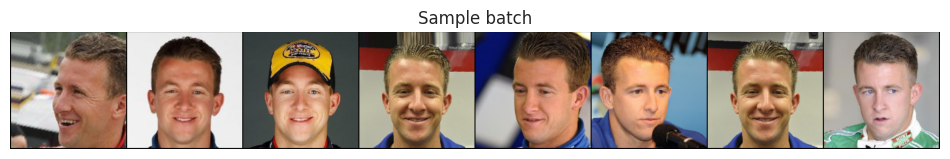

In [7]:
images, labels, _ = next(iter(train_dataloader))

imgs = images[:8] * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)

# Show a grid of 8 images
grid = torchvision.utils.make_grid(imgs, nrow=8)#, normalize=True, value_range=(0, 1))

plt.figure(figsize=(12, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.title("Sample batch")
plt.show()

### Binary concept presence table (training and test set)

In [8]:
from datasets import Value

attribute_columns = [attr for attr in dataset['historical_train'].features if attr not in ['image', 'celeb_id', 'image_id', 'is_drift', 'Male']]

if TEST_DRIFT:
    from datasets import concatenate_datasets

    if INCLUDE_TARGET:
        attribute_columns = [attr for attr in dataset['historical_train'].features if attr not in ['image', 'celeb_id', 'image_id', 'is_drift']]

    train_concept_presence = concatenate_datasets([dataset['datastream_no_drift'], dataset['datastream_drift']]).select_columns(attribute_columns)
else:
    train_concept_presence = dataset['historical_train'].select_columns(attribute_columns)

# cast to float
for col in train_concept_presence.column_names:
    if train_concept_presence.features[col].dtype == "bool":
        train_concept_presence = train_concept_presence.cast_column(col, Value(dtype="float"))

train_concept_presence = train_concept_presence.to_pandas()
train_concept_presence

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155946,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
155947,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
155948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
155949,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [9]:
# Extract Concept presence table for test set (drift / no drift)
test_nodrift_concept_presence = dataset['datastream_no_drift'].select_columns(attribute_columns)
test_drift_concept_presence = dataset['datastream_drift'].select_columns(attribute_columns)

# cast to float
for col in test_nodrift_concept_presence.column_names:
    if test_nodrift_concept_presence.features[col].dtype == "bool":
        test_nodrift_concept_presence = test_nodrift_concept_presence.cast_column(col, Value(dtype="float"))

for col in test_drift_concept_presence.column_names:
    if test_drift_concept_presence.features[col].dtype == "bool":
        test_drift_concept_presence = test_drift_concept_presence.cast_column(col, Value(dtype="float"))


test_nodrift_concept_presence = test_nodrift_concept_presence.to_pandas()
test_drift_concept_presence = test_drift_concept_presence.to_pandas()
test_drift_concept_presence

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1345,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1346,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1347,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
if TEST_DRIFT:
    # Extract labels for train and test sets
    train_original_label = pd.DataFrame([0. if i < len(train_dataset) / 2 else 1. for i in range(len(train_dataset))], columns=['Drift'])

    test_nodrift_original_label = pd.DataFrame([0. for _ in range(len(test_dataset))], columns=['Drift'])

    test_drift_original_label = pd.DataFrame([1. for _ in range(len(test_dataset_drift))], columns=['Drift'])
else:
    # Extract labels for train and test sets
    train_original_label = (dataset['historical_train']
                            .select_columns(['Male'])
                            .cast_column('Male', Value(dtype="float"))
                            .to_pandas())

    test_nodrift_original_label = (dataset['datastream_no_drift']
                                   .select_columns(['Male'])
                                   .cast_column('Male', Value(dtype="float"))
                                   .to_pandas())

    test_drift_original_label = (dataset['datastream_drift']
                                 .select_columns(['Male'])
                                 .cast_column('Male', Value(dtype="float"))
                                 .to_pandas())


Mean concept presence: 0.22171691338288538


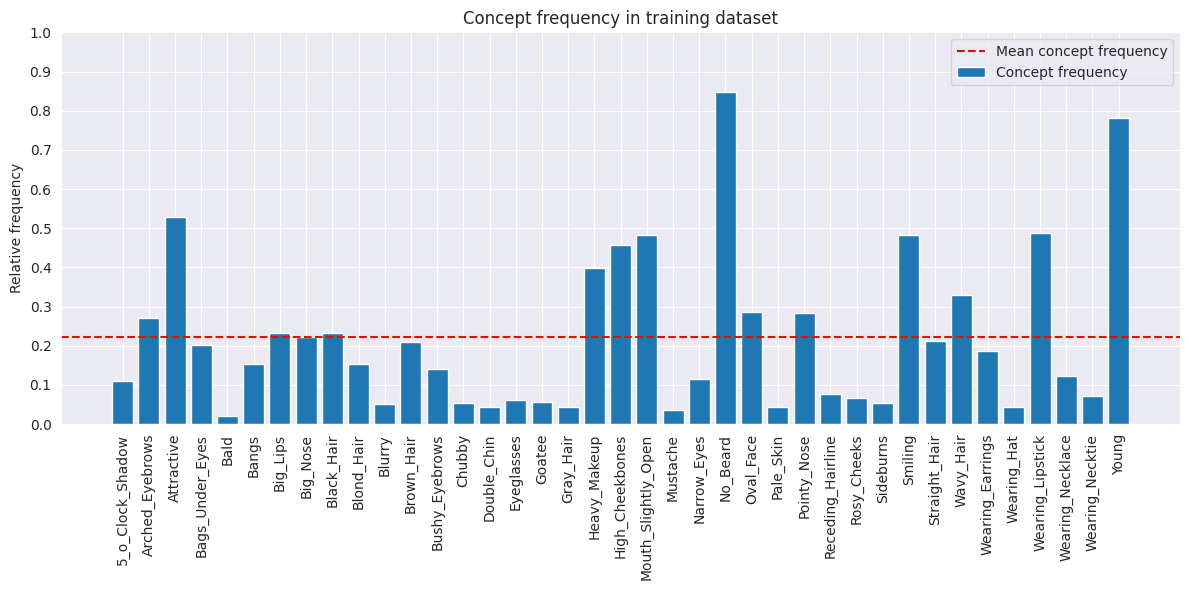

In [11]:
concept_freq = {
    col: sum(train_concept_presence[col])/len(train_concept_presence) for col in train_concept_presence.columns
}

mean_concept_freq = np.mean(list(concept_freq.values()))
print(f'Mean concept presence: {mean_concept_freq}')

plt.figure(figsize=(12,6))
plt.bar(train_concept_presence.columns, concept_freq.values(), label='Concept frequency')
plt.axhline(mean_concept_freq, color='red', linestyle='--', label='Mean concept frequency')
plt.ylabel('Relative frequency')
plt.title('Concept frequency in training dataset')
plt.xticks(train_concept_presence.columns, rotation=90)
plt.yticks(np.arange(0.,1.1,0.1))
plt.legend()
plt.tight_layout()
plt.savefig('concept_freq.pdf')

### Create ERIC for Symbolic Rule Extraction

In [12]:
from eric_extractor import ERICExtractor

NUM_CLASSES = 2
encoder = None

eric = ERICExtractor(encoder, num_classes=NUM_CLASSES)

In [13]:
def _extract_rules(binary_activations, labels_list, test_binary_activations, test_labels_list, tree_max_depth=5):
        """
        Extract symbolic rules using ERIC.
        """

        all_binary_activations = binary_activations
        all_labels = labels_list

        all_labels = torch.cat(all_labels) if isinstance(all_labels[0], torch.Tensor) else torch.tensor(all_labels)

        test_all_binary_activations = test_binary_activations
        test_all_labels = test_labels_list

        test_all_labels = torch.cat(test_all_labels) if isinstance(test_all_labels[0], torch.Tensor) else torch.tensor(test_all_labels)

        rules = eric.extract_rules(
            all_binary_activations,
            all_labels,
            test_all_binary_activations,
            test_all_labels,
            max_depth=tree_max_depth
        )

        return rules


Best fidelity (train): 0.9382498348840341
Best fidelity: 0.9355734954917173
Best depth: 16


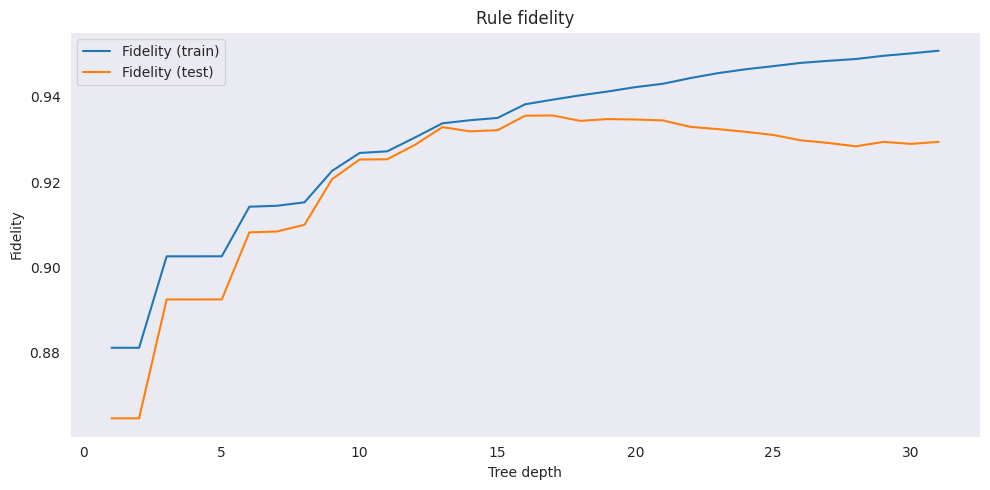

In [14]:
# Find optimal tree depth
tree_depths = range(1, 32)
rule_fidelities = []
rule_fidelities_test = []
best_depth, best_fidelity, best_fidelity_train = 0, 0, 0

for depth in tree_depths:
    _ = _extract_rules(
        torch.tensor(train_concept_presence.values),
        train_original_label['Male' if not TEST_DRIFT else 'Drift'].tolist(),
        torch.tensor(test_nodrift_concept_presence.values),
        test_nodrift_original_label['Male' if not TEST_DRIFT else 'Drift'].tolist(),
        tree_max_depth=depth
    )
    rule_fidelities.append(eric.rule_fidelity)
    rule_fidelities_test.append(eric.rule_fidelity_test)

    if eric.rule_fidelity_test - best_fidelity > 0.005:
        best_fidelity = eric.rule_fidelity_test
        best_fidelity_train = eric.rule_fidelity
        best_depth = depth

print("Best fidelity (train):", best_fidelity_train)
print("Best fidelity:", best_fidelity)
print("Best depth:", best_depth)

plt.figure(figsize=(10,5))
plt.plot(tree_depths, rule_fidelities, label="Fidelity (train)")
plt.plot(tree_depths, rule_fidelities_test, label="Fidelity (test)")
plt.xlabel("Tree depth")
plt.ylabel("Fidelity")
plt.title("Rule fidelity")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('rule_fidelity.pdf')

In [15]:
# Extract and analyze symbolic rules
print(f"Extracting symbolic rules...(using best_max_depth={best_depth})")
# To approximate the FC classifier, use the model prediction on the training set instead of labels_list
rules = _extract_rules(
    torch.tensor(train_concept_presence.values),
    train_original_label['Male' if not TEST_DRIFT else 'Drift'].tolist(),
    torch.tensor(test_nodrift_concept_presence.values),
    test_nodrift_original_label['Male' if not TEST_DRIFT else 'Drift'].tolist(),
    tree_max_depth=5
)
rules


Extracting symbolic rules...(using best_max_depth=16)


[{'antecedent': [(-1, 35), (-1, 23), (-1, 33), (-1, 10), (-1, 7)],
  'consequent': 1,
  'confidence': 0.9982473117087275,
  'samples': 0},
 {'antecedent': [(-1, 35), (-1, 23), (-1, 33), (-1, 10), (1, 7)],
  'consequent': 1,
  'confidence': 0.9995449557791259,
  'samples': 1},
 {'antecedent': [(-1, 35), (-1, 23), (-1, 33), (1, 10), (-1, 7)],
  'consequent': 1,
  'confidence': 0.9825651966193398,
  'samples': 0},
 {'antecedent': [(-1, 35), (-1, 23), (-1, 33), (1, 10), (1, 7)],
  'consequent': 1,
  'confidence': 1.0,
  'samples': 1},
 {'antecedent': [(-1, 35), (-1, 23), (1, 33)],
  'consequent': 0,
  'confidence': 1.0,
  'samples': 1},
 {'antecedent': [(-1, 35), (1, 23), (-1, 33), (-1, 37), (-1, 7)],
  'consequent': 1,
  'confidence': 0.6947346748654675,
  'samples': 1},
 {'antecedent': [(-1, 35), (1, 23), (-1, 33), (-1, 37), (1, 7)],
  'consequent': 1,
  'confidence': 0.9102087851433924,
  'samples': 0},
 {'antecedent': [(-1, 35), (1, 23), (-1, 33), (1, 37), (-1, 7)],
  'consequent': 1,


In [16]:
for rule in rules:
    string_rules = eric.rule_to_string(rule)
    print(string_rules)

¬kernel_35 ∧ ¬kernel_23 ∧ ¬kernel_33 ∧ ¬kernel_10 ∧ ¬kernel_7 → Class_1 (conf=1.00)
¬kernel_35 ∧ ¬kernel_23 ∧ ¬kernel_33 ∧ ¬kernel_10 ∧ kernel_7 → Class_1 (conf=1.00)
¬kernel_35 ∧ ¬kernel_23 ∧ ¬kernel_33 ∧ kernel_10 ∧ ¬kernel_7 → Class_1 (conf=0.98)
¬kernel_35 ∧ ¬kernel_23 ∧ ¬kernel_33 ∧ kernel_10 ∧ kernel_7 → Class_1 (conf=1.00)
¬kernel_35 ∧ ¬kernel_23 ∧ kernel_33 → Class_0 (conf=1.00)
¬kernel_35 ∧ kernel_23 ∧ ¬kernel_33 ∧ ¬kernel_37 ∧ ¬kernel_7 → Class_1 (conf=0.69)
¬kernel_35 ∧ kernel_23 ∧ ¬kernel_33 ∧ ¬kernel_37 ∧ kernel_7 → Class_1 (conf=0.91)
¬kernel_35 ∧ kernel_23 ∧ ¬kernel_33 ∧ kernel_37 ∧ ¬kernel_7 → Class_1 (conf=1.00)
¬kernel_35 ∧ kernel_23 ∧ ¬kernel_33 ∧ kernel_37 ∧ kernel_7 → Class_1 (conf=1.00)
¬kernel_35 ∧ kernel_23 ∧ kernel_33 → Class_0 (conf=1.00)
kernel_35 ∧ ¬kernel_18 ∧ ¬kernel_33 ∧ ¬kernel_12 ∧ ¬kernel_5 → Class_0 (conf=0.98)
kernel_35 ∧ ¬kernel_18 ∧ ¬kernel_33 ∧ ¬kernel_12 ∧ kernel_5 → Class_0 (conf=0.93)
kernel_35 ∧ ¬kernel_18 ∧ ¬kernel_33 ∧ kernel_12 ∧ ¬kernel_5 

In [17]:
#names = list(df_kernel_concepts.keys())
names = list(train_concept_presence.columns)

for rule in rules:
    string_rules = eric.rule_to_string(rule, names)
    print(string_rules)

¬Wearing_Lipstick ∧ ¬No_Beard ∧ ¬Wearing_Earrings ∧ ¬Blurry ∧ ¬Big_Nose → Class_1 (conf=1.00)
¬Wearing_Lipstick ∧ ¬No_Beard ∧ ¬Wearing_Earrings ∧ ¬Blurry ∧ Big_Nose → Class_1 (conf=1.00)
¬Wearing_Lipstick ∧ ¬No_Beard ∧ ¬Wearing_Earrings ∧ Blurry ∧ ¬Big_Nose → Class_1 (conf=0.98)
¬Wearing_Lipstick ∧ ¬No_Beard ∧ ¬Wearing_Earrings ∧ Blurry ∧ Big_Nose → Class_1 (conf=1.00)
¬Wearing_Lipstick ∧ ¬No_Beard ∧ Wearing_Earrings → Class_0 (conf=1.00)
¬Wearing_Lipstick ∧ No_Beard ∧ ¬Wearing_Earrings ∧ ¬Wearing_Necktie ∧ ¬Big_Nose → Class_1 (conf=0.69)
¬Wearing_Lipstick ∧ No_Beard ∧ ¬Wearing_Earrings ∧ ¬Wearing_Necktie ∧ Big_Nose → Class_1 (conf=0.91)
¬Wearing_Lipstick ∧ No_Beard ∧ ¬Wearing_Earrings ∧ Wearing_Necktie ∧ ¬Big_Nose → Class_1 (conf=1.00)
¬Wearing_Lipstick ∧ No_Beard ∧ ¬Wearing_Earrings ∧ Wearing_Necktie ∧ Big_Nose → Class_1 (conf=1.00)
¬Wearing_Lipstick ∧ No_Beard ∧ Wearing_Earrings → Class_0 (conf=1.00)
Wearing_Lipstick ∧ ¬Heavy_Makeup ∧ ¬Wearing_Earrings ∧ ¬Bushy_Eyebrows ∧ ¬Bangs → C

In [18]:
print(f'Rule fidelity (train): {eric.rule_fidelity}')
print(f'Rule fidelity (test no drift): {eric.rule_fidelity_test}')

Rule fidelity (train): 0.9026040230585248
Rule fidelity (test no drift): 0.892482700775844


In [19]:
# Accuracy on test set (drift)
test_drift_predictions = eric.dt.predict(test_drift_concept_presence.values)
acc_drift_test = np.mean(test_drift_predictions == test_drift_original_label.values)
acc_drift_test

0.0

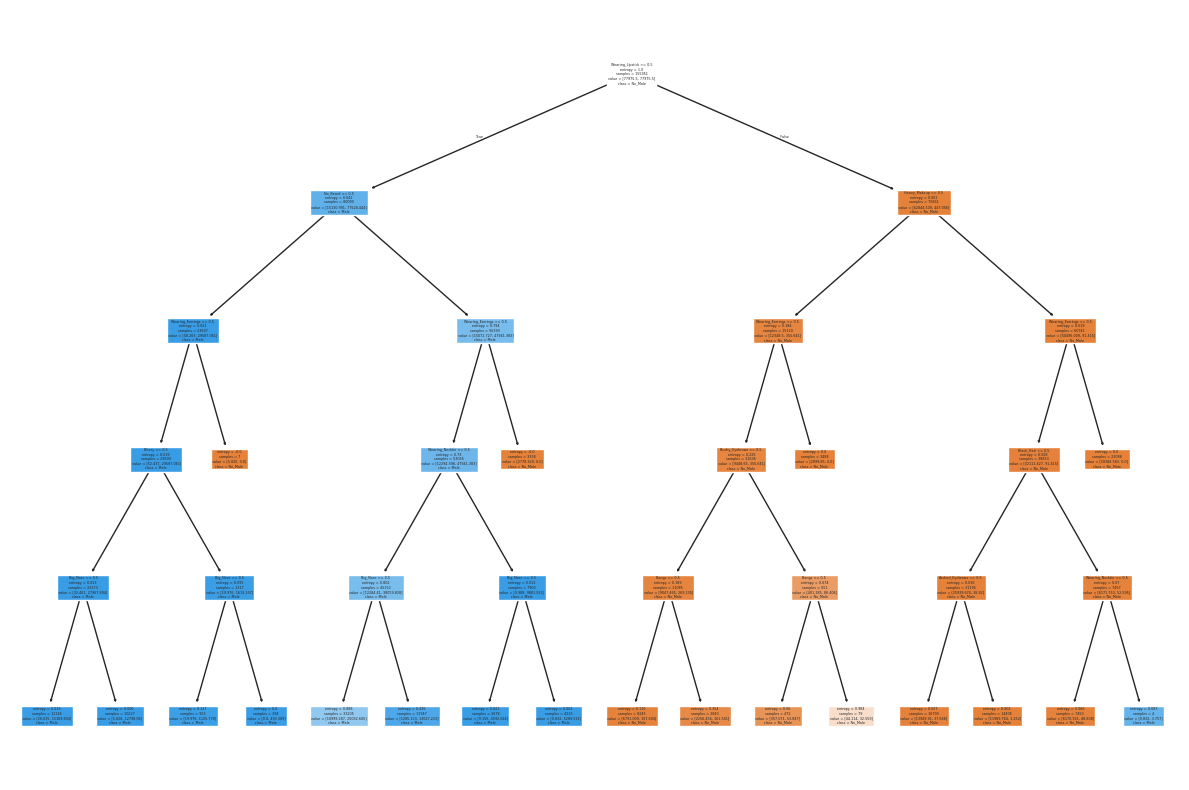

In [20]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12,8))
plot_tree(
    eric.dt,
    filled=True,
    feature_names=list(train_concept_presence.columns),
    class_names=['No_Male', 'Male']
)
plt.tight_layout()
plt.savefig('tree.pdf')

In [21]:
len(list(train_concept_presence.columns))

39

### Extract rule satisfied by the image

In [22]:
def explain_decision(clf, sample, feature_names, class_names, print_rule=False):
    if print_rule:
        print("Explaining decision:")
    node_indicator = clf.decision_path(sample)
    node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]

    final_rule = []
    prediction = None

    for node_id in node_index:
        if clf.tree_.feature[node_id] != -2:
            fname = feature_names[clf.tree_.feature[node_id]]
            threshold_val = clf.tree_.threshold[node_id]
            sample_val = sample.iloc[0, clf.tree_.feature[node_id]]
            op = "<=" if sample_val <= threshold_val else ">"
            if print_rule:
                print(f"{fname} = {sample_val:.3f} {op} {threshold_val:.3f}")
            final_rule.append(f'¬{fname}' if sample_val <= threshold_val else fname)
        else:
            if print_rule:
                print(f"Leaf node → predict class: {clf.classes_[np.argmax(clf.tree_.value[node_id])]}")
            prediction = class_names[int(clf.classes_[np.argmax(clf.tree_.value[node_id])])]

    final_rule = f"{' ∧ '.join(final_rule)} → {prediction}"

    if print_rule:
        print("Final rule:")
        print(final_rule)

    return final_rule


### Inference no drift

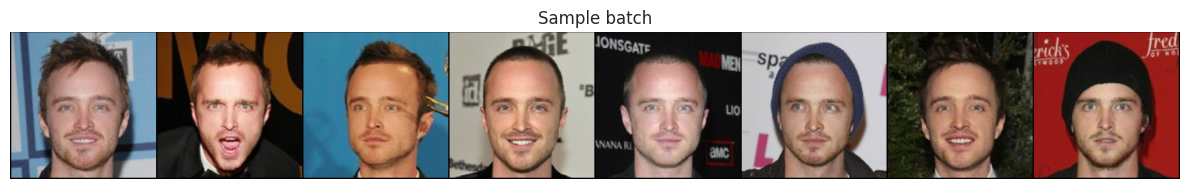

In [23]:
images, labels, _ = next(iter(test_dataloader))

imgs = images[:8] * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)

# Show a grid of 8 images
grid = torchvision.utils.make_grid(imgs, nrow=8)#, normalize=False, value_range=(0, 1))

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.title("Sample batch")
plt.tight_layout()
plt.savefig('sample_nodrift.png')

In [24]:
test_nodrift_concept_presence.iloc[[0]]

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
SAMPLE = 0

_ = explain_decision(
    eric.dt,
    test_nodrift_concept_presence.iloc[[SAMPLE]],
    list(test_nodrift_concept_presence.columns),
    class_names=['No_Male', 'Male'] if not TEST_DRIFT else ['No_Drift', 'Drift'],
    print_rule=True
)

Explaining decision:
Wearing_Lipstick = 0.000 <= 0.500
No_Beard = 0.000 <= 0.500
Wearing_Earrings = 0.000 <= 0.500
Blurry = 0.000 <= 0.500
Big_Nose = 0.000 <= 0.500
Leaf node → predict class: 1.0
Final rule:
¬Wearing_Lipstick ∧ ¬No_Beard ∧ ¬Wearing_Earrings ∧ ¬Blurry ∧ ¬Big_Nose → Male


/home/thesis/anaconda3/envs/sg-diff/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


### Inference drift

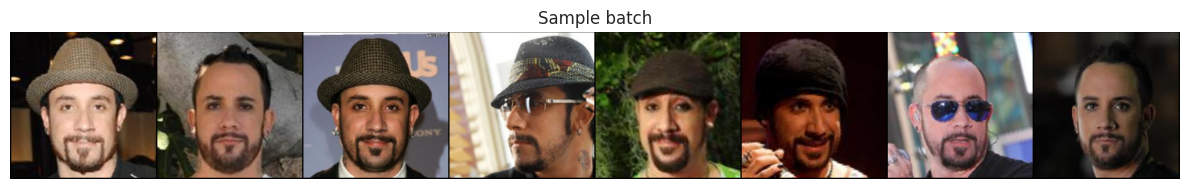

In [26]:
images, labels, _ = next(iter(test_dataloader_drift))

imgs = images[:8] * torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1)

# Show a grid of 8 images
grid = torchvision.utils.make_grid(imgs, nrow=8)#, normalize=False, value_range=(0, 1))

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')
plt.title("Sample batch")
plt.tight_layout()
plt.savefig('sample_drift.png')

In [27]:
test_drift_concept_presence.iloc[[0]]

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [28]:
SAMPLE = 0

_ = explain_decision(
    eric.dt,
    test_drift_concept_presence.iloc[[SAMPLE]],
    list(test_drift_concept_presence.columns),
    class_names=['No_Male', 'Male'] if not TEST_DRIFT else ['No_Drift', 'Drift'],
    print_rule=True
)

Explaining decision:
Wearing_Lipstick = 0.000 <= 0.500
No_Beard = 0.000 <= 0.500
Wearing_Earrings = 1.000 > 0.500
Leaf node → predict class: 0.0
Final rule:
¬Wearing_Lipstick ∧ ¬No_Beard ∧ Wearing_Earrings → No_Male


/home/thesis/anaconda3/envs/sg-diff/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


### Antecedents frequencies (Gender)

In [29]:
# Compute antecedent frequencies on wrong predictions (test set - drift)

from collections import Counter
import warnings
warnings.filterwarnings("ignore")


print(f"No drift samples: {len(test_nodrift_concept_presence)}")
print(f"Drift samples: {len(test_drift_concept_presence)}")

rules_nodrift, rules_drift = [], []

for i in range(len(test_nodrift_concept_presence)):
    rule = explain_decision(
        eric.dt,
        test_nodrift_concept_presence.iloc[[i]],
        list(test_nodrift_concept_presence.columns),
        class_names=['No_Male', 'Male'] if not TEST_DRIFT else ['No_Drift', 'Drift']
    )
    rules_nodrift.append(rule)

for i in range(len(test_drift_concept_presence)):
    rule = explain_decision(
        eric.dt,
        test_drift_concept_presence.iloc[[i]],
        list(test_drift_concept_presence.columns),
        class_names=['No_Male', 'Male'] if not TEST_DRIFT else ['No_Drift', 'Drift']
    )
    rules_drift.append(rule)


antecedents_nodrift, antecedents_drift = [], []

for rule in rules_nodrift:
    antecedents_nodrift.extend(rule.split(' → ')[0].split(' ∧ '))

for rule in rules_drift:
    antecedents_drift.extend(rule.split(' → ')[0].split(' ∧ '))


antecedents_nodrift_count = dict(Counter(antecedents_nodrift))
antecedents_drift_count = dict(Counter(antecedents_drift))

antecedents_nodrift_freq = {k: round(v / len(test_nodrift_concept_presence), 2) for k, v in antecedents_nodrift_count.items()}
antecedents_drift_freq = {k: round(v / len(test_drift_concept_presence), 2) for k, v in antecedents_drift_count.items()}


print("No drift count:")
print(antecedents_nodrift_count)
print(len(antecedents_nodrift_count))
print("Drift count:")
print(antecedents_drift_count)
print(len(antecedents_drift_count))

print("No drift freq:")
print(antecedents_nodrift_freq)
print("Drift freq:")
print(antecedents_drift_freq)


No drift samples: 19076
Drift samples: 1349
No drift count:
{'¬Wearing_Lipstick': 10239, '¬No_Beard': 3062, '¬Wearing_Earrings': 15413, '¬Blurry': 2920, '¬Big_Nose': 6290, 'No_Beard': 7177, '¬Wearing_Necktie': 6384, 'Big_Nose': 3417, 'Wearing_Necktie': 916, 'Blurry': 142, 'Wearing_Lipstick': 8837, 'Heavy_Makeup': 7494, '¬Black_Hair': 4033, '¬Arched_Eyebrows': 2295, 'Wearing_Earrings': 3663, 'Arched_Eyebrows': 1738, '¬Heavy_Makeup': 1343, '¬Bushy_Eyebrows': 975, '¬Bangs': 777, 'Bushy_Eyebrows': 43, 'Black_Hair': 655, 'Bangs': 241}
22
Drift count:
{'¬Wearing_Lipstick': 1315, '¬No_Beard': 801, 'Wearing_Earrings': 1349, 'Wearing_Lipstick': 34, 'Heavy_Makeup': 26, 'No_Beard': 514, '¬Heavy_Makeup': 8}
7
No drift freq:
{'¬Wearing_Lipstick': 0.54, '¬No_Beard': 0.16, '¬Wearing_Earrings': 0.81, '¬Blurry': 0.15, '¬Big_Nose': 0.33, 'No_Beard': 0.38, '¬Wearing_Necktie': 0.33, 'Big_Nose': 0.18, 'Wearing_Necktie': 0.05, 'Blurry': 0.01, 'Wearing_Lipstick': 0.46, 'Heavy_Makeup': 0.39, '¬Black_Hair': 0.